## Routines

In [1]:
import tensorflow as tf
import numpy as np 
import os 
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter

def triangular_plot(chains):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)# randomly initialize the points
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i}")
    for i in range(ndim):
        for j in range(i):
            plt.subplot(ndim,ndim,ndim*i+j+1)
            counts,xbins,ybins,image = plt.hist2d(data[:,j],data[:,i],bins=100
                                      ,norm=LogNorm()
                                      , cmap = plt.cm.rainbow)
            plt.colorbar()
            plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
            linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
    plt.show()

def triangular_plot_slopes(chains):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(15,15))
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j}/x{i}")
            #ax.set_ylabel(f"x{i}")
    plt.show()

2024-11-12 17:14:03.117048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 17:14:03.186090: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 17:14:03.204237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 17:14:03.287648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 17:14:05.191322: W tensorflow/compiler/tf2

### Definition of the potentials and functions to get the gradients

In [2]:
# number of points
n_points = 10000

def V4log(x):
    x1,x3,ex7,ex9=tf.split(x, 4, axis=1)
    return 0.5 * (ex7 ** 6 -4 * (-1 + x1 ** 2 + x3 ** 2) + (ex7 ** -6) * ((x1 ** 2 + x3 ** 2) ** 2) + 2 * (ex7 ** -4) * (ex9 ** (-2 * (3 ** -0.5))) * ((ex9 ** (np.sqrt(3))) * (x1 ** 2) + x3 ** 2) + 2 * (ex7 ** 4) * (ex9 ** (-(3 ** -0.5))) * (x1 ** 2 + (ex9 ** (np.sqrt(3))) * (x3 ** 2)) + (ex7 ** 2) * (ex9 ** (-2 * (3 ** -0.5))) * (-2 + x1 ** 4 + (ex9 ** (2 * (np.sqrt(3)))) * (x3 ** 4) + 2 * (ex9 ** (np.sqrt(3))) * (-2 + (x1 ** 2) * (x3 ** 2))) + (ex7 ** -2) * (ex9 ** (-4 * (3 ** -0.5))) * (1 -2 * (ex9 ** (2 * (np.sqrt(3)))) * (x3 ** 2) * (x1 ** 2 + x3 ** 2) -2 * (ex9 ** (np.sqrt(3))) * (2 + x1 ** 4 + (x1 ** 2) * (x3 ** 2))))

# compute (||∇V||^2)
def grad_norm_squared(V, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

def get_grad(V, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    return gradients

### Definition of the gradient descent

In [3]:
def grad_descent(V,x,init_alpha,nb_steps,threshold,update_rate,update_alpha):
    optimizer = tf.optimizers.Adam(learning_rate=init_alpha) # Opimizer for the gradient descent
    #optimizer = tf.optimizers.Adam(learning_rate=alpha)

    alpha = init_alpha
    loss_history = np.zeros(nb_steps)

    for step in range(nb_steps):  
        with tf.GradientTape() as tape:
            loss = tf.reduce_sum(grad_norm_squared(V, x))  # minimize ||∇V||^2 for all points
    
        # Compute ||∇V||^2 with respect to x
        gradients = tape.gradient(loss, [x])
        
        if update_rate:
            if update_alpha and step % 300 == 0 and step != 0:
                alpha = alpha/2
                optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
            if (not update_alpha) and step % 200 ==0 :
                optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
            if loss.numpy()<10:
                update_alpha = True
            
        # Apply gradient descent for all points
        optimizer.apply_gradients(zip(gradients, [x]))

        loss_history[step] = loss.numpy()
        
        if step % 500 == 0:
            print(f"Step {step}: ||∇V||^2 = {np.format_float_scientific(loss.numpy(), unique=False, precision=1),alpha}")
            
        if np.log(loss.numpy())/np.log(10)<threshold: 
            print("Converged enough") 
            print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
            break

    return loss_history

# Filtering

In [4]:
xnp= np.load('data/x_V13d_x13eq0.npy')

In [6]:
xnp.shape

(10000, 12)

In [29]:
mask = (np.abs(xnp[:,0])<0.1) 

for i in [1,3,4,5,7,9,10,11]:
    mask = mask * (np.abs(xnp[:,i])<0.1)

mask.sum()

1028

In [30]:
xnpfiltered=xnp[mask]

xnpfiltered.shape

(1028, 12)

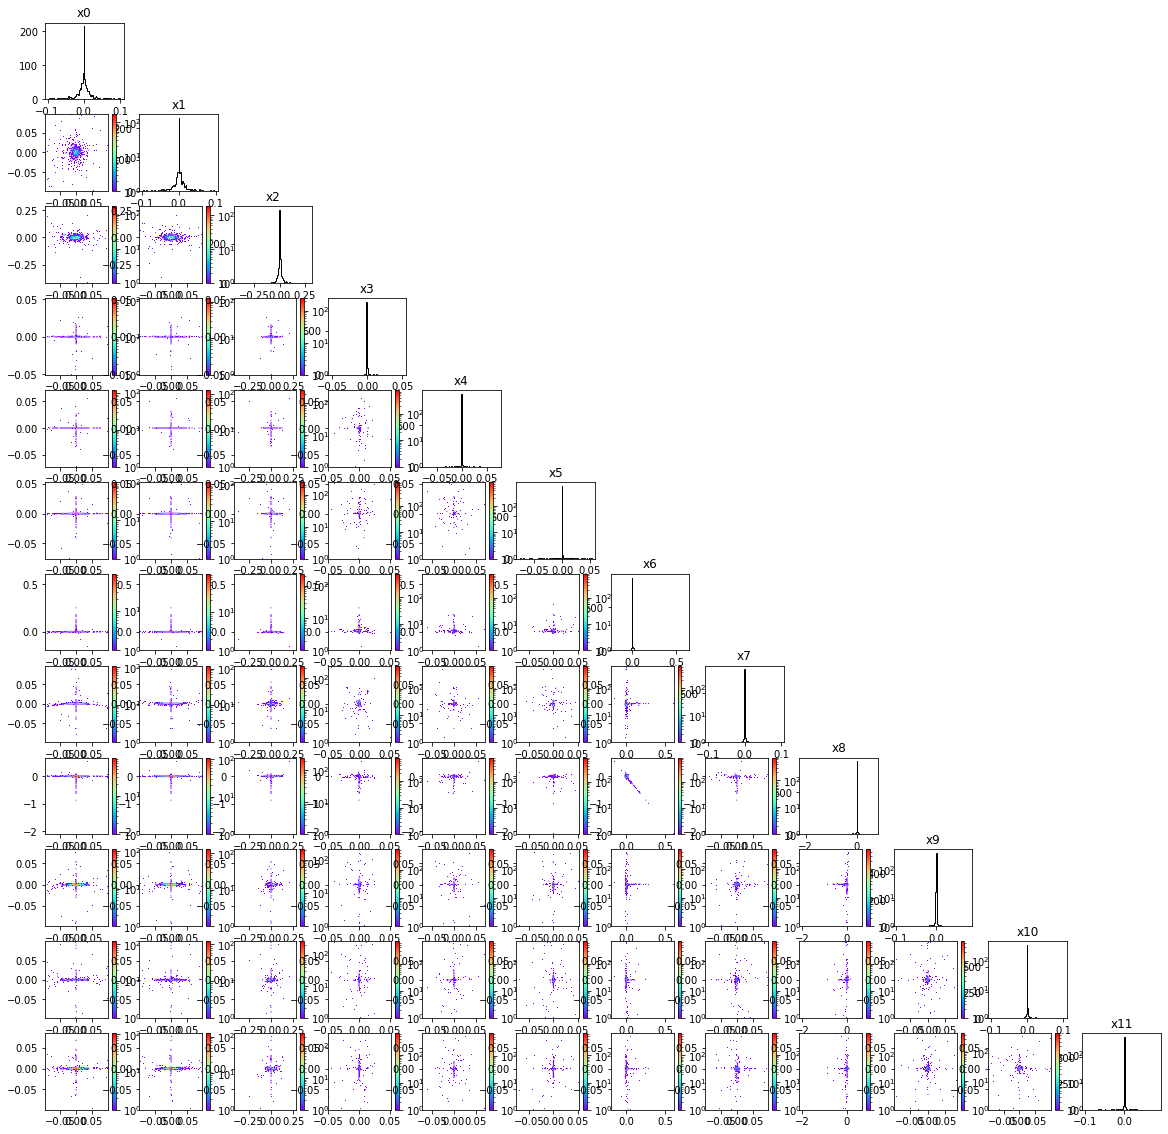

In [31]:
triangular_plot(xnpfiltered)